In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence
import pandas as pd
import mne
import os
import EDFlib
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from sklearn.model_selection import train_test_split
import warnings
from collections import OrderedDict

# Suppress FutureWarning and RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [1]:
study_dir = './study'
data_dir = f'{study_dir}/data'
extract_dir = f'{study_dir}/extracted'

### EEG files extraction 

* The EEG files for each patient can be extracted based on the dictionary of regions of interest
* The extracted raw files are saved as .edf files in their respective folders

In [3]:
def create_extracted_files(df, p, roi_dict, num):
    """ A function to extract the relevant channels from the EEG files based on ROI

    Args
        df (DataFrame): The dataframe that consists information about which region of the brain is affected for each patient (ROI)
        p (str): The current patient ID
        roi_dict (dict): The ROI dictionary which contains IDs of the relevant channels
        num (str): The ID of current timeframe under consideration (ex. '1M', '8M' etc.)
        
    Returns 
        None
    """
    names_of_ch = []
    roi = df.loc[df['Subject Id'] == p, 'Q682'].values[0]
    print(roi)
    list_of_ch = roi_dict[roi]
    print(list_of_ch)
    for i in list_of_ch:
        names_of_ch.append(f'EEG {i}-VREF')
        
    channels_256_pats = ['a', 'b', 'c', 'l', 'm']
    # since the above patients have a different naming scheme than the 10-20 system, the 'names_of_ch' variable is used
    if p in channels_256_pats:
        raw_obj = mne.io.read_raw_edf(f'eeg/{p}/{p}-{num}.edf', include=names_of_ch, preload=False)
    else: # for other patients the list_of_ch can be used directly
        raw_obj = mne.io.read_raw_edf(f'eeg/{p}/{p}-{num}.edf', include=list_of_ch, preload=False)
        
    raw_obj = raw_obj.resample(sfreq=250)
    mne.export.export_raw(f'eeg_extracted/{p}/{p}_{num}_ROI.edf', raw_obj, overwrite=True)


# for C, L, E, G, H, I, J, L, O, P the timepoints are all present but for other patients some of the timepoints are missing
# A, B, M has Base to 16M only; D has Base, 1M, 8M, and 24M; N has Base to 24M; F has Base to 8M 
 
def run_extraction(pats, roi_dict):
    """This function is used for the ease of processing differnet batches of patients seperately
    each timepoint needs to be defined seperately for batches of patients 
    as the data availability for each patient is different
    Args
        pats: the current list of patients being processed
        roi_dict: the region of interest dictionary that consits of the names of the relevant channels
    
    """
    timepoints_1 = ['B', '1M', '8M', '16M', '24M', '36M']
    timepoints_2 = ['B', '1M', '8M', '24M'] # for D

    df = pd.read_excel(f"{data_dir}/F_Scr_MHEp.csv.xlsx", usecols=["Subject Id", "Q682"], index_col=None)

    if not os.path.exists(f'./eeg_extracted'):
        os.mkdir('./eeg_extracted')
        
    for p in pats:
        if not os.path.exists(f'./eeg_extracted/{p}'):
            os.mkdir(f'./eeg_extracted/{p}')
        if not any(os.listdir(f'./eeg_extracted/{p}')):
            print(f'Processing patient {p}...')
            if p in ['a', 'b', 'm']:
                timepoints = timepoints_1[:4]
            elif p == 'n':
                timepoints = timepoints_1[:5]
            elif p == 'f':
                timepoints = timepoints_1[:3]
            elif p == 'd':
                timepoints = timepoints_2
            else:
                timepoints = timepoints_1
    # use foll. loop for performing EEG extraction
            for i in timepoints:
                create_extracted_files(df, p, roi_dict, i)
        else:
            print('Patient already processed')

In [4]:
roi_keys = ['left temporal', 'left frontal', 'right temporal', 'left central', 'frontal', 'left temporoparietal', 
            'left parietal', 'left frontolateral', 'right temporooccipital', 'left parietooccipital', 
            'right frontotemporaldorsal']

# used for a, b, c, l, m
# since these patients follow the 256 channels scheme the following dict is used 
roi_dict = {'left temporal': [47, 48, 49, 54, 55, 56, 61, 62, 63, 68, 69, 70, 73, 74, 75, 83, 84, 94, 95],
            'left frontal': [23, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 50, 51],
            'right temporal': [1, 2, 178, 179, 180, 190, 191, 192, 193, 202, 203, 210, 211, 212, 213, 219, 220, 221, 222],
            'left central': [43, 44, 50, 51, 52,53, 57, 58, 59, 60, 64, 65, 66, 71, 72, 77,78,79, 89],
            'frontal': [5, 6, 7, 8, 14, 15, 16, 17, 21, 22, 23, 24, 30, 43, 197, 198, 206, 207, 215],
            'left temporoparietal': [70, 72, 74, 75, 76,78,83, 84, 85,94, 95, 96,99, 104, 105, 106,108, 114, 115], 
            'left parietal': [72, 75, 76, 77, 78, 85, 86, 87, 88, 95, 96, 97, 98, 99, 104, 105, 106, 107, 108],
            'left frontolateral': [29, 30, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46,  47, 48, 49, 50, 54,55, 56],
            'right temporooccipital': [157, 158, 159, 165, 166, 167, 168, 174, 175, 176, 177, 178, 188, 189, 190, 199, 200, 201, 208],
            'left parietooccipital': [95, 96, 97, 98, 104, 106, 107, 111, 113, 114, 115, 116, 121, 122, 123, 124, 135, 136, 137],
            'right frontotemporaldorsal': [2, 3, 4, 5, 6, 7, 14, 197, 198, 205, 206, 207, 213, 214, 215, 221, 222, 223, 224]}

# for other patients the 10-20 system is used, but some patients like d,e,p have suffix as 'G2'
# while other patients have Ref as suffix
# among the other patients 'g' has slightly different names with some small letters instead of capital
# example: G has EEG Fz-Ref while others have EEG FZ-Ref

# used for d, e, p
channels_10_20_dep = ['EEG Fp1-G2', 'EEG Fp2-G2', 'EEG F7-G2', 'EEG F3-G2', 'EEG Fz-G2', 'EEG F4-G2', 'EEG F8-G2', 
                  'EEG T3-G2', 'EEG C3-G2', 'EEG Cz-G2', 'EEG C4-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG P3-G2', 
                  'EEG Pz-G2', 'EEG P4-G2', 'EEG T6-G2', 'EEG O1-G2', 'EEG O2-G2']
# used for g
channels_10_20_g = ['EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG F3-Ref', 'EEG F4-Ref', 'EEG F7-Ref', 'EEG F8-Ref', 
                      'EEG Fz-Ref', 'EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG O1-Ref', 'EEG O2-Ref', 'EEG P3-Ref',
                      'EEG P4-Ref', 'EEG Pz-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG T5-Ref', 'EEG T6-Ref']

# used for f, h, i, j, n, o
channels_10_20 = ['EEG C3-Ref', 'EEG C4-Ref', 'EEG CZ-Ref', 'EEG F3-Ref', 'EEG F4-Ref', 'EEG F7-Ref', 'EEG F8-Ref', 
                      'EEG FZ-Ref', 'EEG FP1-Ref', 'EEG FP2-Ref', 'EEG O1-Ref', 'EEG O2-Ref', 'EEG P3-Ref',
                      'EEG P4-Ref', 'EEG PZ-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG T5-Ref', 'EEG T6-Ref']



In [5]:
# change the curr_dict according to the relevant channels
curr_pats = ['a','b', 'c', 'l','m']
curr_dict = roi_dict
run_extraction(curr_pats, curr_dict)

curr_pats = ['d', 'e', 'p']
curr_dict = {key: channels_10_20_dep for key in roi_keys}
run_extraction(curr_pats, curr_dict)

curr_pats = ['f', 'h', 'i', 'j', 'n', 'o']
curr_dict = {key: channels_10_20 for key in roi_keys}
run_extraction(curr_pats, curr_dict)

curr_pats = ['g']
curr_dict = curr_dict = {key: channels_10_20_g for key in roi_keys}
run_extraction(curr_pats, curr_dict)


Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed
Patient already processed


### Below Cell is not necessary as each patient now has a constant number of channels

In [6]:
# p = 'a'
# # custom montage for hdEEG
# data_raw = mne.io.read_raw_edf(f'eeg_extracted_backup/{p}/{p}_1M_ROI.edf', preload=False)
# custom_montage = mne.channels.read_custom_montage("./GSN-HydroCel-256Epilognlr_mne_python.elc")

# data_raw.set_montage(custom_montage)

# # keep only 10-20 channels

# if reduce_hd_eeg:

#                 print("Reducing hdEEG to 10-20 EEG")

#                 channels_all = data_raw.ch_names

#                 channels_1020 = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T3", "C3",

#                                                                                  "C4", "T4", "T5", "P3", "Pz", "P4", "T6", "O1", "O2", "E81"] # + E81 since hdEEG has no Cz

#                 data_raw.pick(channels_1020)

#                 data_raw.rename_channels(mapping={"E81": "Cz"}) # use E81 as Cz surrogate

# # not working, not necessary?

## EEG Analysis


In [7]:
patients = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l','m', 'n', 'o','p']

labels = {}

for patient_id in patients:
    if patient_id == 'k':
        continue  # Skip patient 'k'
    if os.path.exists(f'./CSD_matrices/Patient-{patient_id}.npy'):
        print(f'CSD_matrices for {patient_id} already calculated')
        continue
        
    file_path = f'eeg_extracted/{patient_id}/{patient_id}_B_ROI.edf'
    raw = mne.io.read_raw_edf(file_path)

    # the duration=40s is approved by Patrick Reisinger
    # consequetive epochs of 40s are generated for each patient (total of 90 40s epochs)
    epochs = mne.make_fixed_length_epochs(raw, duration=40, preload=1)
    
    if len(epochs) > 90:
        epochs = epochs[:90]
        
    combined_parts = []
    # Compute CSD matrix
    csd_matrix = mne.time_frequency.csd_fourier(epochs, fmax=150)
    # Average the CSD matrix across epochs
    avg_csd_matrix = csd_matrix.mean().get_data()
    print(avg_csd_matrix.shape)
    # Flatten the averaged CSD matrix
    flattened_csd = avg_csd_matrix.flatten()
    
    for i in range(len(flattened_csd)):
        # real, img = split_at_second_occurrence(flattened_csd[i])
        real = flattened_csd[i].real
        img = flattened_csd[i].imag
        combined_parts.extend([real, img])

    if not os.path.exists('./CSD_matrices'):
        os.mkdir('./CSD_matrices')
    np.save(f'./CSD_matrices/Patient-{patient_id}.npy', np.array(combined_parts))
    
    print(np.array(combined_parts).shape)

CSD_matrices for a already calculated
CSD_matrices for b already calculated
CSD_matrices for c already calculated
CSD_matrices for d already calculated
CSD_matrices for e already calculated
CSD_matrices for f already calculated
CSD_matrices for g already calculated
CSD_matrices for h already calculated
CSD_matrices for i already calculated
CSD_matrices for j already calculated
CSD_matrices for l already calculated
CSD_matrices for m already calculated
CSD_matrices for n already calculated
CSD_matrices for o already calculated
CSD_matrices for p already calculated


In [8]:
# read the flattened CSD matrices
csd_features = {}
for patient_id in patients:
    csd_features[patient_id] = np.load(f'./CSD_matrices/Patient-{patient_id}.npy')
    
# Convert the dictionary to a DataFrame
size = len(csd_features['a']) # can choose any patient for the total size since all the patients are of the same size
csd_df = pd.DataFrame.from_dict(csd_features, orient='index', columns=[f'f_{i}' for i in range(size)])

labels = OrderedDict()
for p in patients:
    labels[p] = 1 if p in ['a', 'c', 'g', 'i', 'j', 'o', 'p'] else 0

# Convert the labels dictionary to a DataFrame
labels_df = pd.DataFrame.from_dict(labels, orient='index', columns=['Status'])
csd_df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_712,f_713,f_714,f_715,f_716,f_717,f_718,f_719,f_720,f_721
a,1.110329e-10,0.0,6.998128e-11,-4.988077e-12,2.775953e-11,-5.015911e-12,2.985535e-11,-3.681676e-12,9.705981e-11,2.615297e-12,...,1.263788e-10,-1.139827e-11,2.990424e-11,-1.334173e-11,1.322840e-10,-1.529989e-11,6.566205e-11,-6.852917e-12,2.032169e-10,0.0
b,4.827836e-10,0.0,4.640128e-10,3.076312e-12,3.819148e-10,2.362776e-11,4.320382e-10,1.589873e-11,4.208925e-10,4.183106e-12,...,3.380349e-10,2.165076e-12,3.517092e-10,3.570077e-12,3.485477e-10,3.232069e-12,3.434546e-10,-4.116568e-13,3.600814e-10,0.0
c,9.322869e-11,0.0,4.912525e-12,-4.765862e-13,3.348326e-11,-1.261671e-12,5.054674e-12,-5.624354e-12,1.166601e-11,2.649295e-12,...,4.963940e-10,3.222302e-11,3.611864e-10,1.043773e-10,2.977553e-11,8.821801e-12,7.332710e-10,-8.058734e-11,5.471064e-10,0.0
d,6.468464e-12,0.0,-3.888253e-12,-2.940689e-12,2.024709e-12,-3.748369e-13,1.571543e-12,-2.370144e-13,-1.276617e-12,-1.945703e-13,...,2.302545e-11,-7.464606e-14,2.349671e-11,-1.018060e-14,2.428072e-11,2.040825e-13,2.457599e-11,9.257715e-14,2.486797e-11,0.0
e,3.434983e-11,0.0,-1.823389e-11,-5.015172e-13,4.285499e-11,2.747409e-13,4.269607e-11,6.502739e-13,4.347437e-11,1.258641e-12,...,6.352111e-11,-2.871163e-13,6.359071e-11,-4.653861e-13,6.449353e-11,-3.810623e-13,6.416193e-11,-2.501536e-14,8.717184e-11,0.0
f,1.422856e-10,0.0,1.517536e-10,-8.546907e-12,1.153956e-10,2.006085e-11,1.518709e-10,-7.527909e-12,1.532493e-10,-8.996444e-12,...,1.421451e-10,1.501725e-11,1.634235e-10,-1.004587e-12,1.709742e-10,-4.022819e-12,1.600329e-10,4.361341e-12,1.824689e-10,0.0
g,4.244541e-10,0.0,4.263948e-10,-3.956508e-12,4.224526e-10,3.927938e-12,4.257245e-10,-1.801892e-12,4.309188e-10,-5.455984e-12,...,3.537024e-10,4.878732e-11,4.190957e-10,-8.415849e-12,4.327735e-10,-6.972838e-12,4.204593e-10,-3.329999e-13,1.683944e-09,0.0
h,1.791124e-10,0.0,1.930722e-10,-1.420305e-11,-1.670095e-11,1.398297e-10,1.940281e-10,-1.263356e-11,2.138461e-10,-2.390889e-11,...,1.154217e-10,4.503962e-11,2.222906e-10,6.791722e-13,2.309038e-10,-3.078517e-12,2.074506e-10,8.476090e-12,2.231572e-10,0.0
i,2.889340e-10,0.0,2.878700e-10,-1.463607e-12,2.850250e-10,4.531382e-12,2.860507e-10,3.870751e-12,2.839704e-10,-5.045176e-12,...,2.700212e-10,6.949004e-12,2.775484e-10,1.942324e-12,2.841515e-10,-1.248989e-12,2.866958e-10,3.743443e-12,2.885578e-10,0.0
j,3.721142e-10,0.0,3.693632e-10,1.124989e-13,2.775094e-10,3.319558e-11,3.687371e-10,6.152367e-12,3.778389e-10,-1.122611e-12,...,3.500318e-10,4.075582e-12,3.816748e-10,-2.442200e-12,3.871539e-10,-7.660812e-12,3.830960e-10,3.222891e-12,4.002633e-10,0.0


In [355]:
import pymc3 as pm
import theano
theano.config.optimizer = 'None'

X_train, X_test, y_train, y_test = train_test_split(csd_df, labels_df, test_size=0.2, random_state=42)
# Define the PyMC3 model with a Bernoulli likelihood
with pm.Model() as bayesian_network:
    # Prior distribution for the structure of the Bayesian Network
    edges = pm.Bernoulli('edges', p=0.5, shape=(722, 722), testval=np.random.binomial(1, 0.5, (722, 722)))
    
    # Specify the conditional probability distributions for each variable
    for i in range(722):
        parents = np.where(edges[i] == 1)[0]
        logit = pm.Normal(f'logit_{i}', mu=0, sd=1)
        pm.Bernoulli(f'obs_{i}', logit=logit + sum([edges[j, i] * X_train[:, j] for j in parents]), observed=y_train)

# Perform inference
with bayesian_network:
    trace = pm.sample(2000, tune=1000, cores=2)


# Use the trained model to perform posterior predictive checks
with bayesian_network:
    # Generate posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=500)

# Extract predicted values for the binary target variable
predicted_Y = posterior_predictive['obs']

# Compute some evaluation metric (e.g., accuracy)
accuracy = (y_test == (predicted_Y.mean(axis=0) > 0.5)).mean()

print(f"Accuracy on Test Set: {accuracy}")


AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

Epoch 1/150
3/3 [==============================] - 0s 66ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.3333
Epoch 2/150
3/3 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5833 - val_loss: 0.6932 - val_accuracy: 0.3333
Epoch 3/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.3333
Epoch 4/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6931 - accuracy: 0.5833 - val_loss: 0.6934 - val_accuracy: 0.3333
Epoch 5/150
3/3 [==============================] - 0s 18ms/step - loss: 0.6931 - accuracy: 0.5833 - val_loss: 0.6934 - val_accuracy: 0.3333
Epoch 6/150
3/3 [==============================] - 0s 17ms/step - loss: 0.6931 - accuracy: 0.5833 - val_loss: 0.6935 - val_accuracy: 0.3333
Epoch 7/150
3/3 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.5833 - val_loss: 0.6935 - val_accuracy: 0.3333
Epoch 8/150
3/3 [===

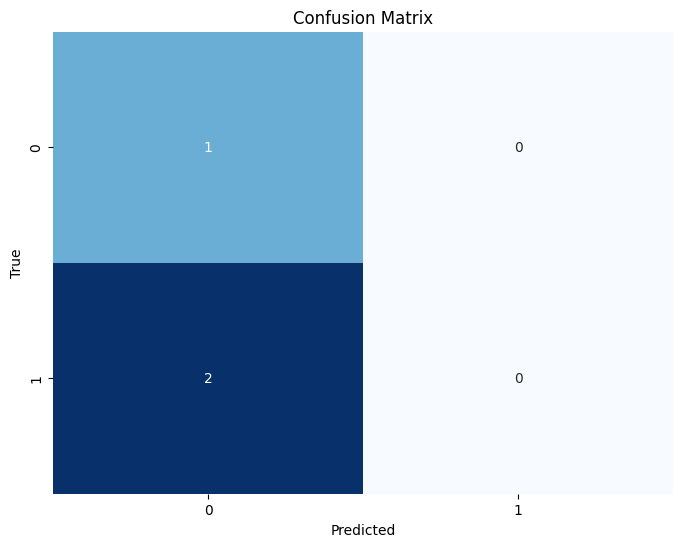

In [383]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Assuming csd_df is your DataFrame with 360 features
num_features = 722

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(csd_df, labels_df, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, input_shape=(num_features,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

custom_optimizer = SGD(learning_rate=1e-3)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=4, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


# Predictions on the test set
y_pred = model.predict(X_test)

# Convert the probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [254]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_tiny_vgg(input_shape, hidden_units, output_shape):
    model = Sequential()
    
    # Convolutional Block 1
    model.add(Conv2D(hidden_units, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(hidden_units, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Convolutional Block 2
    model.add(Conv2D(hidden_units, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(hidden_units, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Classifier
    model.add(Flatten())
    model.add(Dense(output_shape, activation='softmax'))  # Use 'softmax' for multiclass classification
    
    return model

# Example usage:
input_shape = (19, 19, 1)  # Adjust input shape according to your data
hidden_units = 64
output_shape = 1  # Change this to the desired output size

# Create the TinyVGG model
tiny_vgg = create_tiny_vgg(input_shape, hidden_units, output_shape)

# Print model summary
tiny_vgg.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 17, 17, 64)        640       
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 64)          36928     
                                                                 
 conv2d_16 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Assuming csd_df is your DataFrame with 361 flattened features
num_features = 361
X_train, X_test, y_train, y_test = train_test_split(csd_df, labels_df, test_size=0.2, random_state=42)

# Reshape the data for CNN (assuming 19x19 flattened CSD matrices)
X_train_cnn = X_train.values.reshape(-1, 19, 19, 1)
X_test_cnn = X_test.values.reshape(-1, 19, 19, 1)

# Compile the model
tiny_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
tiny_vgg.fit(X_train_cnn, y_train, epochs=100, batch_size=32, validation_data=(X_test_cnn, y_test))

# Evaluate the model on the test set
loss, accuracy = tiny_vgg.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


1/1 [==============================] - 0s 42ms/step
Test Accuracy: 0.6667


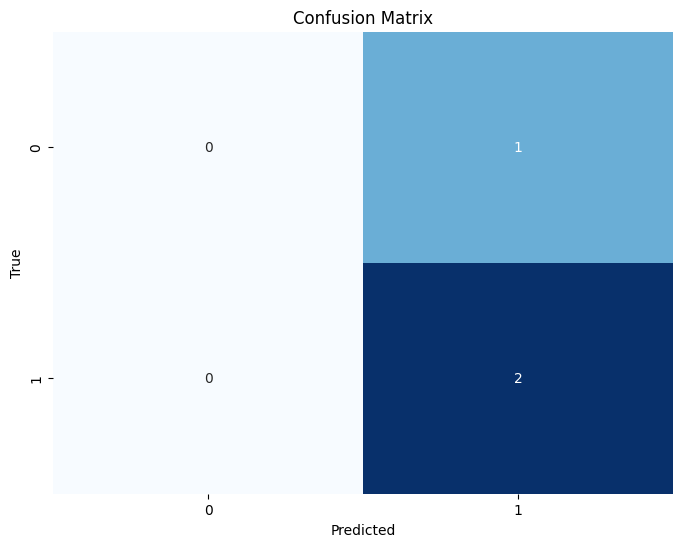

In [267]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming tiny_vgg is your compiled and trained model

# Predictions on the test set
y_pred = tiny_vgg.predict(X_test_cnn)

# Convert the probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
raw_1 = mne.io.read_raw_edf('eeg_extracted/a/a_B_ROI.edf')
raw_2 = mne.io.read_raw_edf('eeg_extracted/b/b_B_ROI.edf')
raw_3 = mne.io.read_raw_edf('eeg_extracted/c/c_B_ROI.edf')
epochs_1 = mne.make_fixed_length_epochs(raw_1, duration=40, preload=1)
epochs_2 = mne.make_fixed_length_epochs(raw_2, duration=40, preload=1)
epochs_3 = mne.make_fixed_length_epochs(raw_3, duration=40, preload=1)

epoch_sets = [epochs_1, epochs_2, epochs_3]

n_times = 10000
Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0], "gamma": [30.0, 125.0]}
n_freq_bands = len(Freq_Bands)
fmin = np.min(list(Freq_Bands.values()))
fmax = np.max(list(Freq_Bands.values()))
freqs = np.linspace(fmin, fmax, int((fmax - fmin) * 4 + 1))
# List to store connectivity matrices for each patient
con_epochs_sets = []
connectivity_methods = ['coh']
n_con_methods = len(connectivity_methods)
# Loop through each set of epochs
for epochs in epoch_sets:
    n_channels = epochs.info['nchan']
    # Pre-allocate memory for the connectivity matrices
    con_epochs_array = np.zeros((n_con_methods, n_channels, n_channels, n_freq_bands, n_times))
    con_epochs_array[con_epochs_array == 0] = np.nan  # nan matrix

    # Compute connectivity over trials
    con_epochs = spectral_connectivity_epochs(
        epochs,
        method=connectivity_methods,
        sfreq=250,
        mode="cwt_morlet",
        cwt_freqs=freqs,
        fmin=fmin,
        fmax=fmax,
        faverage=True, # average = True
    )

    # Get data as connectivity matrices
    for c in range(n_con_methods):
        con_epochs_array[c] = con_epochs[c].get_data(output="dense")

    # Store the connectivity matrices for this patient
    con_epochs_sets.append(con_epochs_array)

# Now, con_epochs_sets contains connectivity matrices for each patient in the order they were processed
for patient_idx, con_epochs_array in enumerate(con_epochs_sets):
    # Loop through each connectivity method (coh, plv)
    for c, connectivity_method in enumerate(connectivity_methods):
        # Loop through each frequency band
        for freq_band_idx in range(n_freq_bands):
            # Get the connectivity matrix for the current patient, method, and frequency band
            connectivity_matrix = con_epochs_array[c, :, :, freq_band_idx, :]

            # Average along the time dimension
            avg_connectivity_matrix = np.mean(connectivity_matrix, axis=-1)

            plt.imshow(avg_connectivity_matrix, cmap='viridis', origin='lower', extent=[0, 10, 0, 10])
            plt.title(f'Connectivity Matrix - {connectivity_method} - Band {freq_band_idx}')
            plt.colorbar()
            plt.xlabel('Channels')
            plt.ylabel('Channels')
            plt.show()

In [292]:
# import numpy as np
# import pandas as pd
# import mne
# from mne.connectivity import spectral_connectivity_epochs
# from sklearn.model_selection import train_test_split

# Assuming 'csd_features' is your dictionary
patients = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p']

coherence_matrices = {}

for patient_id in patients:
    if patient_id == 'k':
        continue  # Skip patient 'k'

    file_path = f'eeg_extracted/{patient_id}/{patient_id}_B_ROI.edf'
    raw = mne.io.read_raw_edf(file_path)
    epochs = mne.make_fixed_length_epochs(raw, duration=40, preload=1)

    # Compute coherence matrix
    coherence_matrix = spectral_connectivity_epochs(
        epochs,
        method='coh',
        sfreq=250,
        mode="cwt_morlet",
        cwt_freqs=np.linspace(4.0, 125.0, int((125.0 - 4.0) * 4 + 1)),
        fmin=4.0,
        fmax=125.0,
        faverage=True,
    )

    # Flatten the coherence matrix
    # flattened_coherence = coherence_matrix.flatten()

    # Save the flattened coherence matrix in the dictionary
    coherence_matrices[patient_id] = coherance_matrix

# # Convert the coherence dictionary to a DataFrame
# coherence_df = pd.DataFrame.from_dict(coherence_matrices, orient='index', columns=[f'coherence_{i}' for i in range(len(flattened_coherence))])

# # Convert the labels dictionary to a DataFrame
# labels_df = pd.DataFrame.from_dict(labels, orient='index', columns=['label'])

# # Display the DataFrames
# print(coherence_df)
# print(labels_df)


Extracting EDF parameters from /home/adaddi/BrainMEP_Raaj/EASEE_BrainMEP/brainmep/eeg_extracted/a/a_B_ROI.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Loading data for 90 events and 10000 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=0.000s..39.996s for estimation (10000 points)
    frequencies: 4.0Hz..125.0Hz (485 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5


NameError: name 'coherance_matrix' is not defined

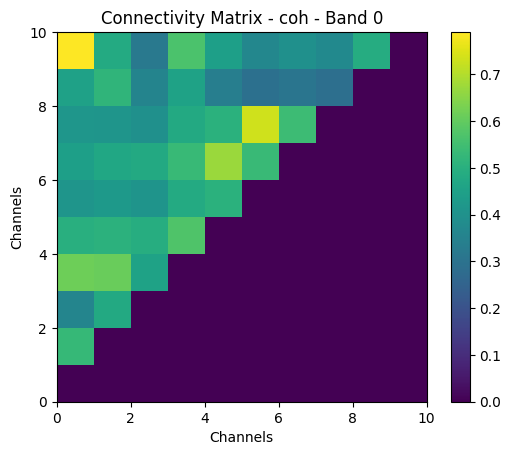

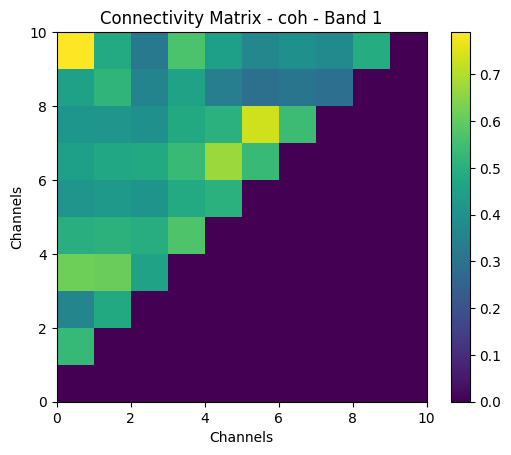

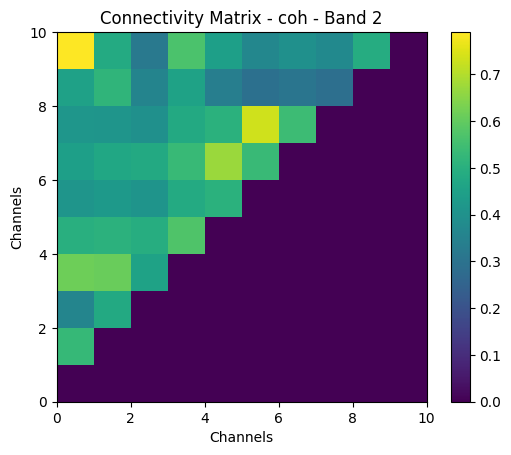

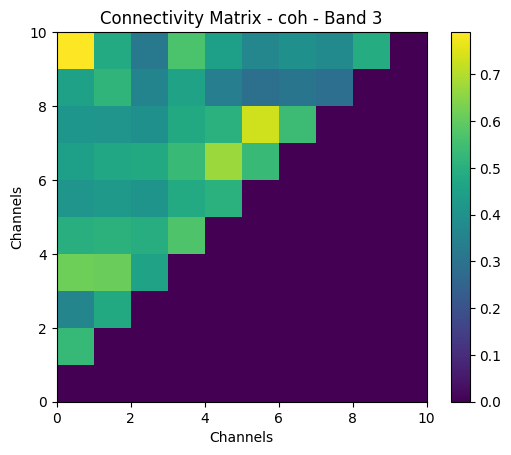

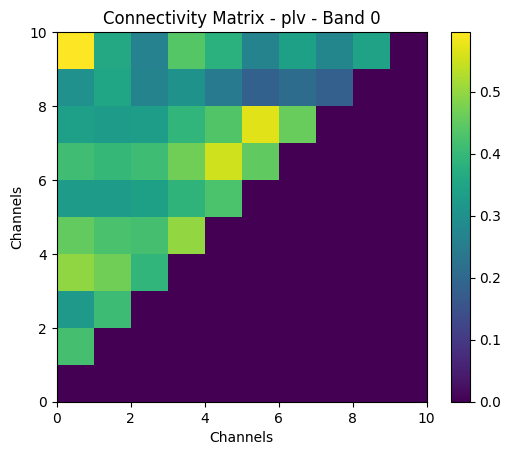

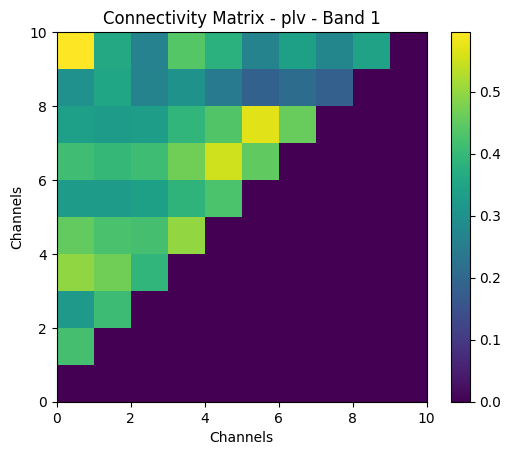

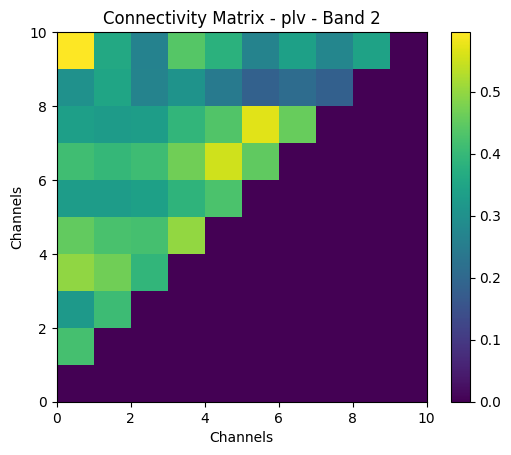

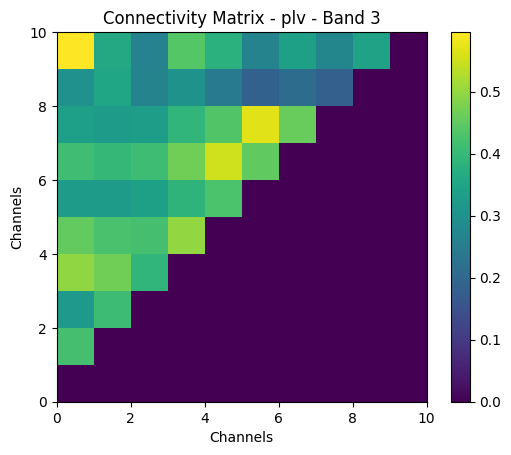

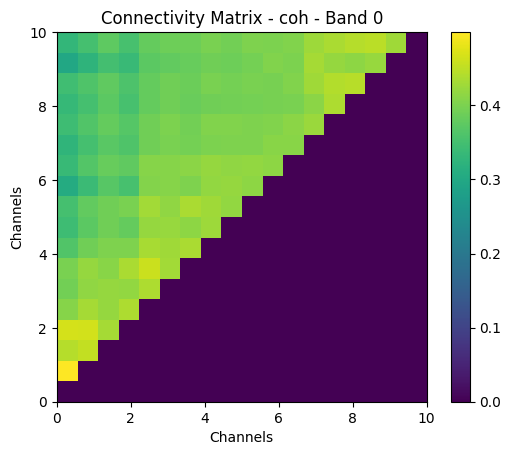

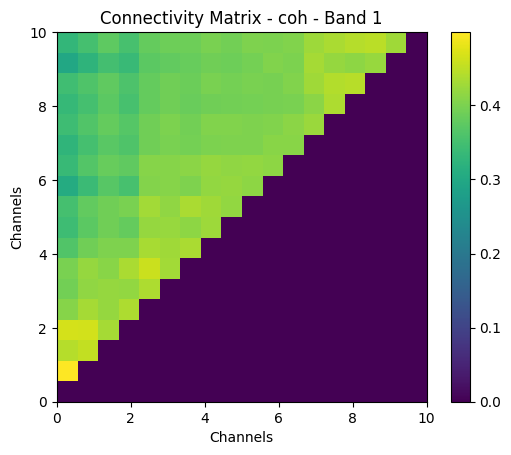

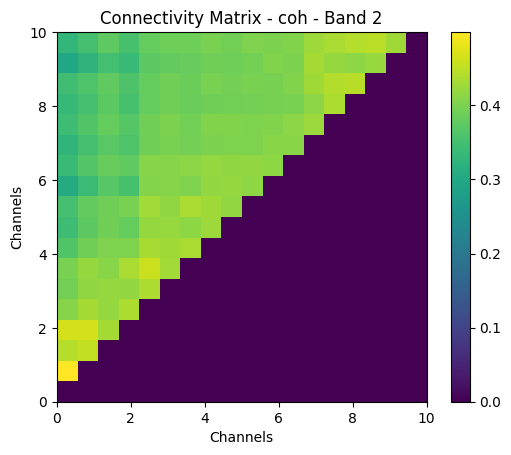

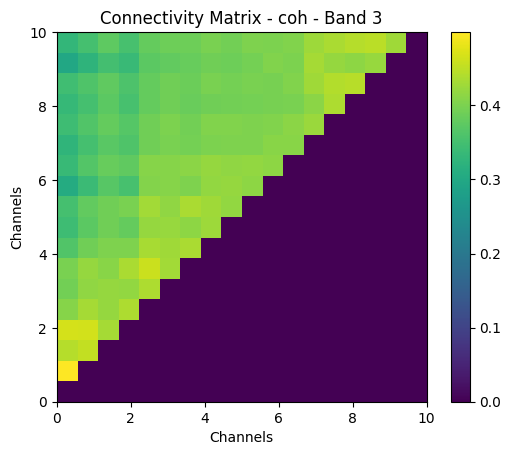

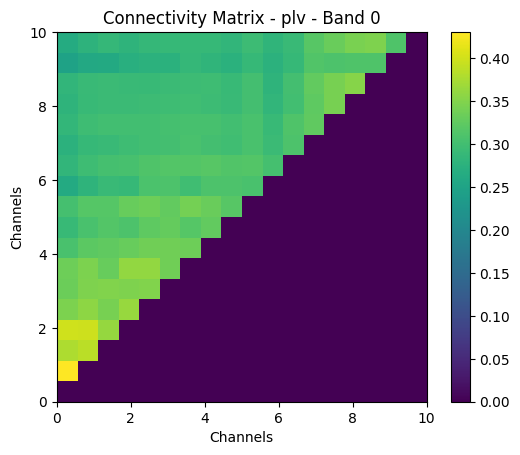

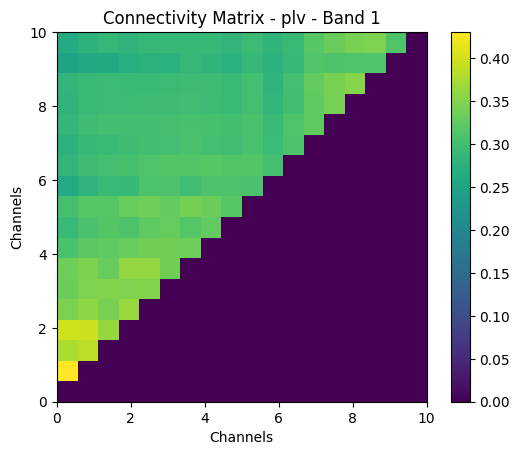

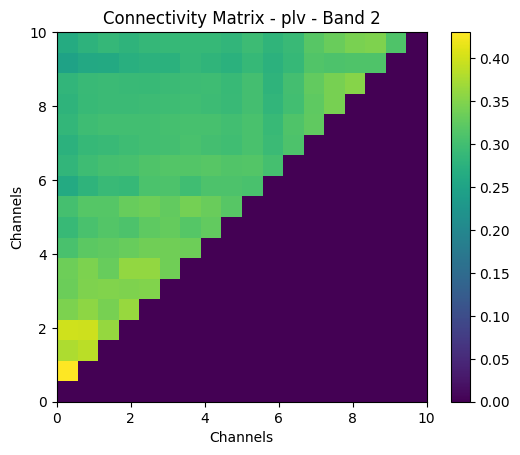

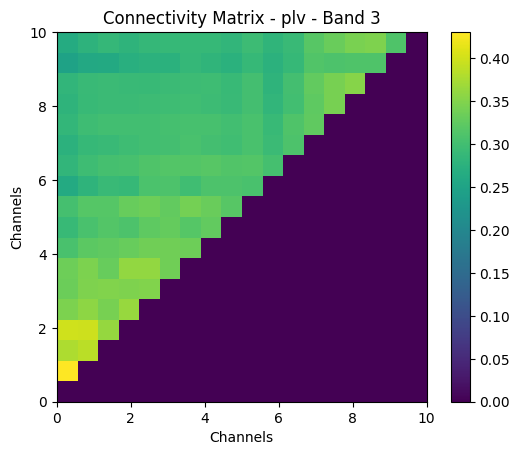

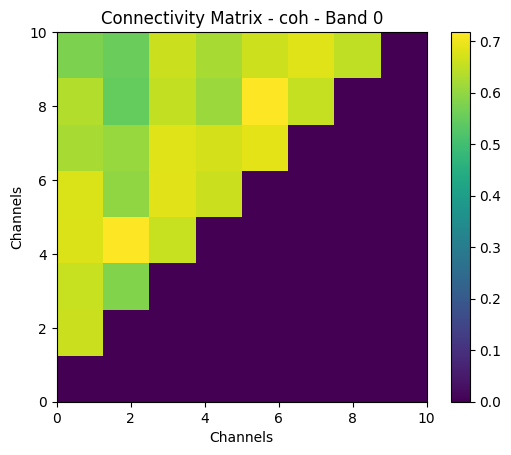

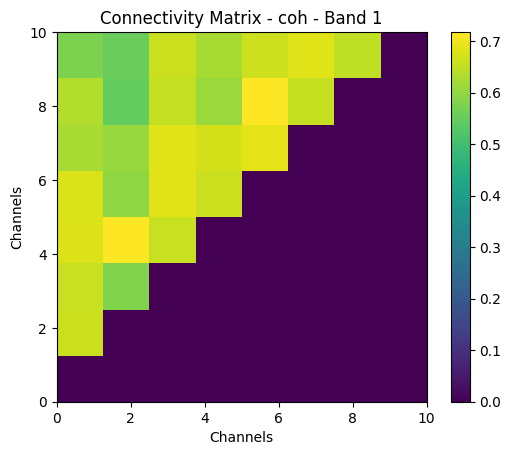

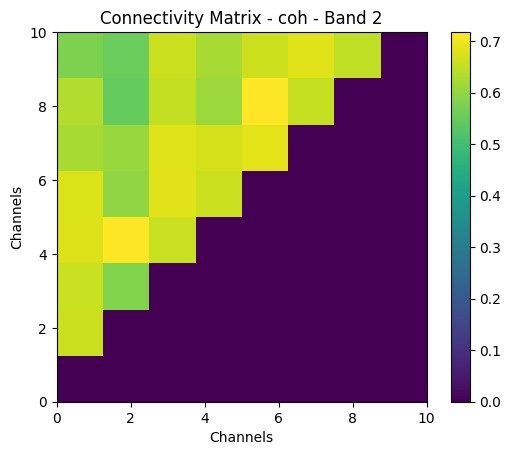

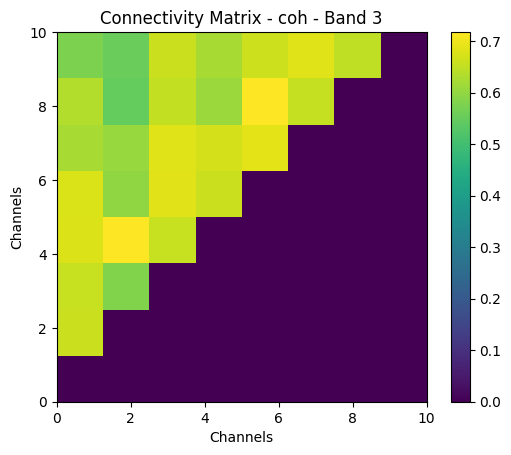

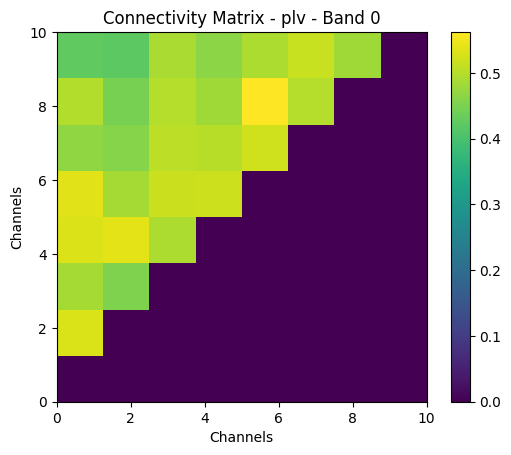

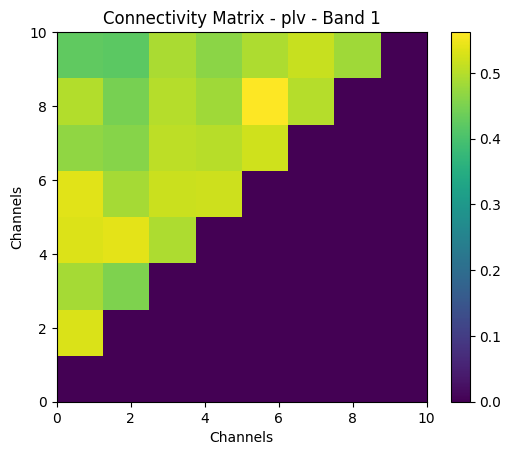

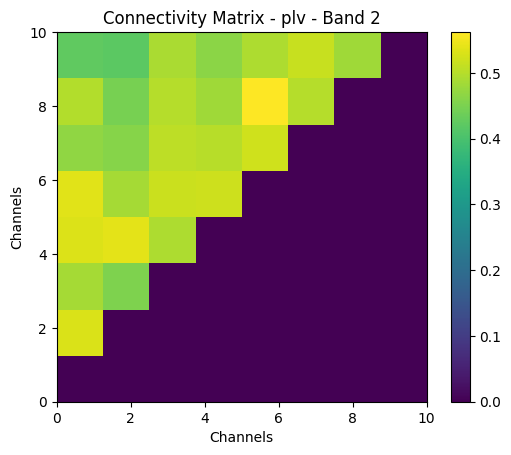

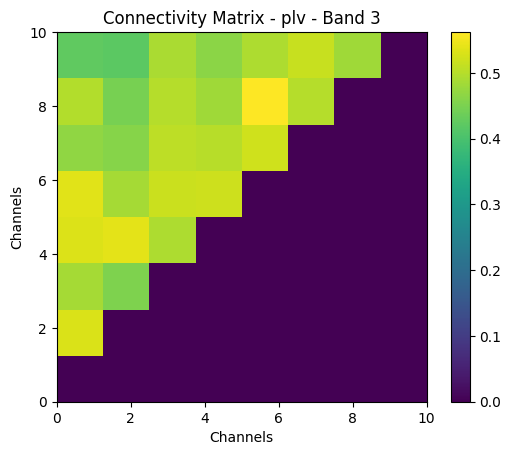